# Homework 2: More Exploratory Data Analysis
## Gene Expression Data and Election Polls 

Due: Thursday, October 2, 2014 11:59 PM

<a href=https://raw.githubusercontent.com/cs109/2014/master/homework/HW2.ipynb download=HW2.ipynb> Download this assignment</a>

#### Submission Instructions
To submit your homework, create a folder named lastname_firstinitial_hw# and place your IPython notebooks, data files, and any other files in this folder. Your IPython Notebooks should be completely executed with the results visible in the notebook. We should not have to run any code. Compress the folder (please use .zip compression) and submit to the CS109 dropbox in the appropriate folder. If we cannot access your work because these directions are not followed correctly, we will not grade your work.


---

## Introduction

John Tukey wrote in [Exploratory Data Analysis, 1977](http://www.amazon.com/Exploratory-Data-Analysis-Wilder-Tukey/dp/0201076160/ref=pd_bbs_sr_2/103-4466654-5303007?ie=UTF8&s=books&qid=1189739816&sr=8-2): "The greatest value of a picture is when it forces us to notice what we never expected to see." In this assignment we will continue using our exploratory data analysis tools, but apply it to new sets of data: [gene expression](http://en.wikipedia.org/wiki/Gene_expression) and polls from the [2012 Presidental Election](http://en.wikipedia.org/wiki/United_States_presidential_election,_2012) and from the [2014 Senate Midterm Elections](http://en.wikipedia.org/wiki/United_States_Senate_elections,_2014).   

**First**: You will use exploratory data analysis and apply the [singular value decomposition](http://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) to a gene expression data matrix to determine if the the date that the gene expression samples are processed has large effect on the variability seen in the data.  

**Second**: You will use the polls from the 2012 Presidential Elections to determine (1) Is there a pollster bias in presidential election polls? and (2) Is the average of polls better than just one poll?

**Finally**: You will use the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to extract the polls for the current 2014 Senate Midterm Elections and provide a preliminary prediction of the result of each state.

#### Data

We will use the following data sets: 

1. A gene expression data set called `exprs_GSE5859.csv` and sample annotation table called `sampleinfo_GSE5859.csv` which are both available on Github in the 2014_data repository: [expression data set](https://github.com/cs109/2014_data/blob/master/exprs_GSE5859.csv) and [sample annotation table](https://github.com/cs109/2014_data/blob/master/sampleinfo_GSE5859.csv).  

2. Polls from the [2012 Presidential Election: Barack Obama vs Mitt Romney](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama). The polls we will use are from the [Huffington Post Pollster](http://elections.huffingtonpost.com/pollster).  

3. Polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api). 

---

## Load Python modules

In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import requests 
from io import StringIO
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
import datetime as dt # module for manipulating dates and times
import numpy.linalg as lin # module for performing linear algebra operations
import os
from scipy.stats import binom

## Problem 1

In this problem we will be using a [gene expression](http://en.wikipedia.org/wiki/Gene_expression) data set obtained from a [microarray](http://en.wikipedia.org/wiki/DNA_microarray) experiement [Read more about the specific experiment here](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE5859).  There are two data sets we will use:  

1. The gene expression intensities where the rows represent the features on the microarray (e.g. genes) and the columsns represent the different microarray samples.  

2. A table that contains the information about each of the samples (columns in the gene expression data set) such as the sex, the age, the treatment status, the date the samples were processed.  Each row represents one sample. 

#### Problem 1(a) 
Read in the two files from Github: [exprs_GSE5859.csv](https://github.com/cs109/2014_data/blob/master/exprs_GSE5859.csv) and [sampleinfo_GSE5859.csv](https://github.com/cs109/2014_data/blob/master/sampleinfo_GSE5859.csv) as pandas DataFrames called `exprs` and `sampleinfo`. Use the gene names as the index of the `exprs` DataFrame.

In [2]:
#your code here
# Not requested but downloaded the files (raw GitHub versions)
exprs_url = 'https://raw.githubusercontent.com/cs109/2014_data/master/exprs_GSE5859.csv'
sampleinfo_url = 'https://raw.githubusercontent.com/cs109/2014_data/master/sampleinfo_GSE5859.csv'
urlDict = {'exprs_GSE5859.csv' : exprs_url , 'sampleinfo_GSE5859.csv' : sampleinfo_url}
if not os.path.exists('data'):
    os.makedirs('data')
for key, value in urlDict.items():
    url_file = requests.get(value)
    open('data/' + key, 'wb').write(url_file.content)
    if key.split('_')[0] == 'exprs':
        exprs = pd.read_csv('data/' + key, index_col = 0)
    else:
        sampleinfo = pd.read_csv('data/' + key)

Make sure the order of the columns in the gene expression DataFrame match the order of file names in the sample annotation DataFrame. If the order of the columns the `exprs` DataFrame do not match the order of the file names in the `sampleinfo` DataFrame, reorder the columns in the `exprs` DataFrame. 

**Note**: The column names of the gene expression DataFrame are the filenames of the orignal files from which these data were obtained.  

**Hint**: The method `list.index(x)` [[read here](https://docs.python.org/2/tutorial/datastructures.html)] can be used to return the index in the list of the first item whose value is x. It is an error if there is no such item. To check if the order of the columns in `exprs` matches the order of the rows in `sampleinfo`, you can check using the method `.all()` on a Boolean or list of Booleans: 

Example code: `(exprs.columns == sampleinfo.filename).all()`

In [3]:
#your code here
(exprs.columns == sampleinfo.filename).all()

False

Result of the check is `False`. Using reindex() the columns order of `exprs` is made identical to the filenames order in `sampleinfo`. See below.

In [4]:
exprs = exprs.reindex(columns = sampleinfo.filename)
(exprs.columns == sampleinfo.filename).all()

True

Show the head of the two tables: `exprs` and `sampleinfo`. 

In [5]:
#your code here
exprs.head()

filename,GSM25349.CEL.gz,GSM25350.CEL.gz,GSM25356.CEL.gz,GSM25357.CEL.gz,GSM25358.CEL.gz,GSM25359.CEL.gz,GSM25360.CEL.gz,GSM25361.CEL.gz,GSM25377.CEL.gz,GSM25378.CEL.gz,...,GSM136719.CEL.gz,GSM136720.CEL.gz,GSM136721.CEL.gz,GSM136722.CEL.gz,GSM136723.CEL.gz,GSM136724.CEL.gz,GSM136725.CEL.gz,GSM136726.CEL.gz,GSM136727.CEL.gz,GSM136729.CEL.gz
1007_s_at,6.627014,6.249807,5.934128,6.145268,6.091270,6.041186,6.050375,6.063847,6.226106,6.358282,...,6.466445,6.533592,6.631492,6.513362,6.440706,6.704324,6.488579,6.809481,6.133068,6.155473
1053_at,6.939184,6.818038,7.047962,7.422477,7.272361,7.128216,6.750719,6.836287,6.738022,7.367895,...,7.032885,7.156344,7.018025,6.973322,6.884738,7.120898,7.517410,7.200596,7.280781,7.111583
117_at,5.113570,5.074096,5.371201,5.266550,5.342047,5.063876,5.315898,5.483652,6.689444,6.482782,...,5.661112,5.127260,5.151840,5.505602,5.687689,4.942651,5.247190,5.237239,5.401876,5.302628
121_at,7.833862,7.780682,7.458197,7.655948,7.546555,7.072670,7.092984,6.954225,7.489785,7.388539,...,7.769734,7.815864,7.683279,7.883231,7.913621,7.834196,7.331864,7.357102,7.607461,7.456453
1255_g_at,3.152269,3.111747,3.018932,3.154545,3.107954,3.224284,3.114241,3.044975,3.304038,2.887919,...,3.257484,3.339234,3.298384,3.150654,3.344501,3.230285,3.175846,3.105092,3.225123,3.090149


In [6]:
sampleinfo.head()

,ethnicity,date,filename,sex
0,CEU,2003-02-04,GSM25349.CEL.gz,M
1,CEU,2003-02-04,GSM25350.CEL.gz,M
2,CEU,2002-12-17,GSM25356.CEL.gz,M
3,CEU,2003-01-30,GSM25357.CEL.gz,M
4,CEU,2003-01-03,GSM25358.CEL.gz,M


#### Problem 1(b)

Extract the year and month as integers from the `sampleinfo` table. 

**Hint**: To convert a Series or a column of a pandas DataFrame that contains a date-like object, you can use the `to_datetime` function [[read here](http://pandas.pydata.org/pandas-docs/stable/timeseries.html)].  This will create a `DatetimeIndex` which can be used to extract the month and year for each row in the DataFrame. 

In [7]:
[[date.year, date.month] for date in (pd.to_datetime(sampleinfo.date))]


[[2003, 2],
 [2003, 2],
 [2002, 12],
 [2003, 1],
 [2003, 1],
 [2003, 1],
 [2003, 1],
 [2003, 2],
 [2002, 12],
 [2002, 12],
 [2002, 12],
 [2003, 1],
 [2002, 12],
 [2002, 12],
 [2002, 11],
 [2002, 12],
 [2003, 1],
 [2003, 2],
 [2003, 2],
 [2002, 12],
 [2002, 11],
 [2002, 11],
 [2002, 11],
 [2002, 11],
 [2002, 11],
 [2002, 11],
 [2002, 12],
 [2002, 12],
 [2002, 11],
 [2002, 11],
 [2002, 11],
 [2002, 12],
 [2003, 1],
 [2003, 1],
 [2003, 1],
 [2003, 1],
 [2003, 3],
 [2003, 3],
 [2003, 3],
 [2003, 3],
 [2003, 4],
 [2003, 4],
 [2003, 1],
 [2003, 1],
 [2003, 1],
 [2003, 1],
 [2003, 2],
 [2003, 2],
 [2003, 1],
 [2003, 2],
 [2003, 3],
 [2003, 3],
 [2002, 10],
 [2002, 11],
 [2002, 10],
 [2002, 11],
 [2002, 12],
 [2003, 1],
 [2003, 1],
 [2003, 1],
 [2003, 1],
 [2003, 1],
 [2003, 1],
 [2003, 3],
 [2003, 1],
 [2003, 1],
 [2003, 1],
 [2003, 1],
 [2003, 1],
 [2002, 11],
 [2002, 12],
 [2003, 1],
 [2002, 12],
 [2002, 12],
 [2003, 2],
 [2003, 2],
 [2003, 2],
 [2003, 2],
 [2003, 2],
 [2003, 2],
 [2003, 2]

#### Problem 1(c)

Convert the dates in the `date` column from the `sampleinfo` table into days since October 31, 2002. Add a column to the `sampleinfo` DataFrame titled `elapsedInDays` containing the days since October 31, 2002.  Show the head of the `sampleinfo` DataFrame which includes the new column.  

**Hint**: Use the `datetime` module to create a new `datetime` object for the specific date October 31, 2002. Then, subtract the October 31, 2002 date from each date from the `date` column in the `sampleinfo` DataFrame. 

In [8]:
#your code here
null_date = dt.datetime.strptime('2002-10-31', "%Y-%m-%d")
sampleinfo['elapsedInDays'] = [(date - null_date).days for date in (pd.to_datetime(sampleinfo.date))]
sampleinfo.head()

,ethnicity,date,filename,sex,elapsedInDays
0,CEU,2003-02-04,GSM25349.CEL.gz,M,96
1,CEU,2003-02-04,GSM25350.CEL.gz,M,96
2,CEU,2002-12-17,GSM25356.CEL.gz,M,47
3,CEU,2003-01-30,GSM25357.CEL.gz,M,91
4,CEU,2003-01-03,GSM25358.CEL.gz,M,64


#### Problem 1(d)

Use exploratory analysis and the singular value decomposition (SVD) of the gene expression data matrix to determine if the date the samples were processed has large effect on the variability seen in the data or if it is just ethnicity (which is confounded with date). 

**Hint**: See the end of the [lecture from 9/23/2014 for help with SVD](http://nbviewer.ipython.org/github/cs109/2014/blob/master/lectures/lecture07/data_scraping_transcript.ipynb). 

First subset the the `sampleinfo` DataFrame to include only the CEU ethnicity.  Call this new subsetted DataFrame `sampleinfoCEU`.  Show the head of `sampleinfoCEU` DataFrame. 

In [9]:
#your code here
sampleinfoCEU = sampleinfo[sampleinfo.ethnicity == 'CEU']
print(sampleinfo.shape, sampleinfoCEU.shape)
sampleinfoCEU.head()

(208, 5) (102, 5)


,ethnicity,date,filename,sex,elapsedInDays
0,CEU,2003-02-04,GSM25349.CEL.gz,M,96
1,CEU,2003-02-04,GSM25350.CEL.gz,M,96
2,CEU,2002-12-17,GSM25356.CEL.gz,M,47
3,CEU,2003-01-30,GSM25357.CEL.gz,M,91
4,CEU,2003-01-03,GSM25358.CEL.gz,M,64


Next, subset the `exprs` DataFrame to only include the samples with the CEU ethnicity. Name this new subsetted DataFrame `exprsCEU`. Show the head of the `exprsCEU` DataFrame. 

In [10]:
#your code here
exprsCEU = exprs[sampleinfoCEU.filename]
print(exprs.shape, exprsCEU.shape)
exprsCEU.head()

(8793, 208) (8793, 102)


filename,GSM25349.CEL.gz,GSM25350.CEL.gz,GSM25356.CEL.gz,GSM25357.CEL.gz,GSM25358.CEL.gz,GSM25359.CEL.gz,GSM25360.CEL.gz,GSM25361.CEL.gz,GSM25377.CEL.gz,GSM25378.CEL.gz,...,GSM48658.CEL.gz,GSM48660.CEL.gz,GSM48661.CEL.gz,GSM48662.CEL.gz,GSM48663.CEL.gz,GSM48664.CEL.gz,GSM48665.CEL.gz,GSM136725.CEL.gz,GSM136726.CEL.gz,GSM136727.CEL.gz
1007_s_at,6.627014,6.249807,5.934128,6.145268,6.091270,6.041186,6.050375,6.063847,6.226106,6.358282,...,6.501510,6.558100,6.618286,6.869995,5.981000,6.403285,6.248702,6.488579,6.809481,6.133068
1053_at,6.939184,6.818038,7.047962,7.422477,7.272361,7.128216,6.750719,6.836287,6.738022,7.367895,...,7.066686,7.386702,6.407958,7.089180,7.120923,7.018998,7.155419,7.517410,7.200596,7.280781
117_at,5.113570,5.074096,5.371201,5.266550,5.342047,5.063876,5.315898,5.483652,6.689444,6.482782,...,5.600514,5.232676,5.630720,4.944748,5.275577,5.770358,5.616842,5.247190,5.237239,5.401876
121_at,7.833862,7.780682,7.458197,7.655948,7.546555,7.072670,7.092984,6.954225,7.489785,7.388539,...,7.437535,7.714650,7.416252,7.746448,8.001434,7.626723,7.452299,7.331864,7.357102,7.607461
1255_g_at,3.152269,3.111747,3.018932,3.154545,3.107954,3.224284,3.114241,3.044975,3.304038,2.887919,...,3.009983,3.151203,3.199709,3.159496,3.149710,3.242780,3.433125,3.175846,3.105092,3.225123


Check to make sure the order of the columns in the `exprsCEU` DataFrame matches the rows in the `sampleinfoCEU` DataFrame.  

In [11]:
#your code here
(exprsCEU.columns == sampleinfoCEU.filename).all()

True

Compute the average gene expression intensity in the `exprsCEU` DataFrame across all the samples. For each sample in the `exprsCEU` DataFrame, subtract the average gene expression intensity from each of the samples. Show the head of the mean normalized gene expression data.  

In [12]:
#some test stuff
# this gives the average per sample (so for each column).
averages = [exprsCEU[sample].mean() for sample in exprsCEU.columns]
averages
# as an array, but identical to above: 
exprsCEU.mean().values

array([5.73733074, 5.74548658, 5.69421707, 5.73058582, 5.71543314,
       5.72239694, 5.71990417, 5.75000972, 5.62447411, 5.72802494,
       5.72089612, 5.72018416, 5.61882464, 5.7105601 , 5.67628944,
       5.69777072, 5.71108855, 5.73710486, 5.70663166, 5.71933617,
       5.69105895, 5.70862674, 5.75872964, 5.7123312 , 5.74255918,
       5.70725937, 5.70635656, 5.70721392, 5.71488029, 5.72256017,
       5.71484641, 5.68586546, 5.73522713, 5.73052619, 5.73311727,
       5.72646498, 5.73423348, 5.74671951, 5.75229941, 5.70081006,
       5.80514663, 5.83549931, 5.71791675, 5.67686615, 5.72084159,
       5.69957116, 5.72635775, 5.740183  , 5.80628184, 5.73050104,
       5.73547426, 5.73392245, 5.68634416, 5.72132628, 5.68666876,
       5.70399787, 5.70401556, 5.71102666, 5.72372581, 5.70940523,
       5.73968523, 5.70692144, 5.70553317, 5.73888087, 5.69843451,
       5.71539934, 5.71015799, 5.72838551, 5.72527184, 5.69099759,
       5.69605903, 5.72042692, 5.72546898, 5.69416922, 5.71685

In [13]:
#your code here
# A sample is defined as "samples (columns in the gene expression data set) "
# So 'across all the samples' is the mean of all sample values per row 
avgs = pd.Series([row.mean() for row in exprsCEU.values])
avgs.values[:5]

array([6.26195526, 7.07521653, 5.60412671, 7.41583546, 3.13393391])

In [14]:
normalized_ged=exprsCEU.subtract(avgs.values, axis=0)
normalized_ged.head()
# another way to get the mean per row I later found is: avgs = exprsCEU.mean(axis=1)

filename,GSM25349.CEL.gz,GSM25350.CEL.gz,GSM25356.CEL.gz,GSM25357.CEL.gz,GSM25358.CEL.gz,GSM25359.CEL.gz,GSM25360.CEL.gz,GSM25361.CEL.gz,GSM25377.CEL.gz,GSM25378.CEL.gz,...,GSM48658.CEL.gz,GSM48660.CEL.gz,GSM48661.CEL.gz,GSM48662.CEL.gz,GSM48663.CEL.gz,GSM48664.CEL.gz,GSM48665.CEL.gz,GSM136725.CEL.gz,GSM136726.CEL.gz,GSM136727.CEL.gz
1007_s_at,0.365059,-0.012149,-0.327827,-0.116687,-0.170685,-0.220769,-0.211580,-0.198109,-0.035849,0.096327,...,0.239554,0.296144,0.356331,0.608040,-0.280956,0.141330,-0.013254,0.226624,0.547526,-0.128887
1053_at,-0.136032,-0.257178,-0.027254,0.347260,0.197144,0.053000,-0.324497,-0.238930,-0.337195,0.292678,...,-0.008531,0.311485,-0.667259,0.013964,0.045706,-0.056219,0.080203,0.442193,0.125379,0.205564
117_at,-0.490556,-0.530031,-0.232926,-0.337577,-0.262080,-0.540250,-0.288228,-0.120475,1.085317,0.878655,...,-0.003613,-0.371451,0.026594,-0.659379,-0.328549,0.166231,0.012716,-0.356936,-0.366887,-0.202251
121_at,0.418026,0.364847,0.042362,0.240113,0.130720,-0.343165,-0.322852,-0.461611,0.073949,-0.027296,...,0.021700,0.298814,0.000417,0.330612,0.585598,0.210887,0.036463,-0.083972,-0.058733,0.191626
1255_g_at,0.018335,-0.022187,-0.115002,0.020611,-0.025980,0.090351,-0.019693,-0.088959,0.170104,-0.246015,...,-0.123951,0.017269,0.065775,0.025562,0.015776,0.108846,0.299192,0.041912,-0.028842,0.091189


Using this mean normalized gene expression data, compute the projection to the first Principal Component (PC1).  

**Hint**: Use the `numpy.linalg.svd()` function in the `numpy.linalg` module (or the `scipy.linalg.svd()` function in the `scipy.linalg` module) to apply an [singular value decomposition](http://en.wikipedia.org/wiki/Singular_value_decomposition) to a matrix.

In [15]:
#your code here
# Subtract mean from data (see cell above) resulted in df normalized_ged
# Matrix normalized_ged [N*M] decomposed by svd() into u [N*N], sigma [N*M] and vh [M*M].
u, sigma, vh = lin.svd(normalized_ged.values, full_matrices=False)
u.shape, sigma.shape, vh.shape
#print(vh, vh.T)

((8793, 102), (102,), (102, 102))

Create a histogram using the values from PC1.  Use a bin size of 25.  

Text(0, 0.5, 'count')

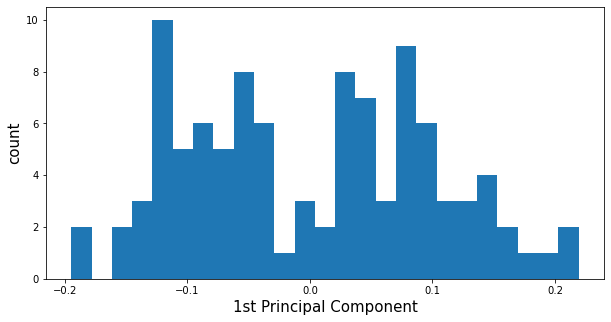

In [16]:
#your code here 
# I.m.o. no need to conjugate, transpose vh (vh.T) and take from first row to last row the values in column 0 [ : ,0].
# Hence took the values in row 0 for first to last column.
plt.figure(figsize=(10,5))
plt.hist(vh[0, : ], bins=25)
plt.xlabel('1st Principal Component', fontsize=15)
plt.ylabel('count', fontsize=15)

Create a scatter plot with the days since October 31, 2002 on the x-axis and PC1 on the y-axis.

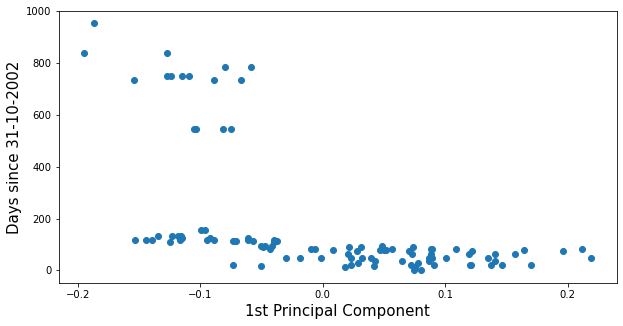

In [17]:
#your code here
plt.figure(figsize=(10,5))
plt.scatter(vh[0, : ], sampleinfoCEU.elapsedInDays)
plt.xlabel('1st Principal Component', fontsize=15)
plt.ylabel('Days since 31-10-2002', fontsize=15)
plt.show()

Around what day do you notice a difference in the way the samples were processed?

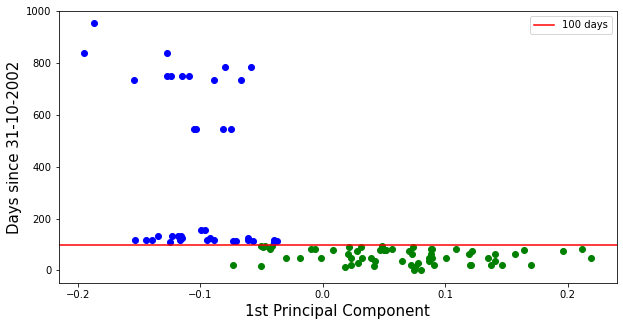

In [18]:
#your code here
plt.figure(figsize=(10, 5))
plt.axhline(y=100, color='r', label = '100 days')
for x,y in zip(vh[0, : ], sampleinfoCEU.elapsedInDays):
    plt.scatter(x, y, color='g') if y <= 100 else plt.scatter(x, y, color='b')
plt.legend()
plt.xlabel('1st Principal Component', fontsize=15)
plt.ylabel('Days since 31-10-2002', fontsize=15)
plt.show()

Answer: of the samples with the CEU ethnicity the Principal Component values above ~100 days all have lower values. And for almost one year no gene samples were registered.

## Discussion for Problem 1

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

---
October 2020: the two 2014 datasets are still available and could be loaded seamlessly into this notebook. Apart from 1(d) most of the Problem 1 homework was straightforward; just wonder why, in 1(b), to extract the year and month as integers from `sampleinfo` as it wasn't used elsewhere.<br>
The Principle Component Analysis required serious browsing to understand it. Without PCA the matrix `normalized_ged` probably would be harder to understand; now the dates the samples where taken indicate an irregular spread as from day 100.

## Problem 2: Is there a pollster bias in presidential election polls?

#### Problem 2(a)

The [HuffPost Pollster](http://elections.huffingtonpost.com/pollster) contains many political polls. You can access these polls from individual races as a CSV but you can also access polls through the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to access the data.  

Read in the polls from the [2012 Presidential Election: Barack Obama vs Mitt Romney](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama) into a pandas DataFrame called `election`. For this problem, you may read in the polls for this race directly using [the CSV file](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv) available from the HuffPost Pollster page.

In [19]:
#your code here
url = 'http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv'
if not os.path.exists('data'):
    os.makedirs('data')
url_file = requests.get(url)
open('data/2012-polls-romney-obama.csv', 'wb').write(url_file.content)
election = pd.read_csv('data/2012-polls-romney-obama.csv')

Show the head of the `election` DataFrame. 

In [20]:
#your code here
election.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Other,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06T08:40:26Z,1000.0,Likely Voters,Live Phone,47.0,47.0,6.0,NaN,https://elections.huffingtonpost.com/pollster/...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None,NaN,1
1,YouGov/Economist,2012-11-03,2012-11-05,2012-11-26T15:31:23Z,740.0,Likely Voters,Internet,49.0,47.0,3.0,NaN,https://elections.huffingtonpost.com/pollster/...,http://cdn.yougov.com/cumulus_uploads/document...,Nonpartisan,None,NaN,1
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06T09:22:02Z,872.0,Likely Voters,Automated Phone,48.0,48.0,4.0,NaN,https://elections.huffingtonpost.com/pollster/...,http://www.gravispolls.com/2012/11/gravis-mark...,Nonpartisan,None,NaN,1
3,IBD/TIPP,2012-11-03,2012-11-05,2012-11-06T08:51:48Z,712.0,Likely Voters,Live Phone,50.0,49.0,NaN,1.0,https://elections.huffingtonpost.com/pollster/...,http://news.investors.com/special-report/50841...,Nonpartisan,None,NaN,1
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06T08:47:50Z,1500.0,Likely Voters,Automated Phone,48.0,49.0,NaN,NaN,https://elections.huffingtonpost.com/pollster/...,http://www.rasmussenreports.com/public_content...,Nonpartisan,None,NaN,1


How many polls were conducted in November? Define this number as M.  

**Hint**: Subset the `election` DataFrame for only dates in the `Start Date` column that are in November 2012.  

In [21]:
#your code here
pollsNovember = election[election['Start Date'].str.contains('2012-11')]
M = len(pollsNovember)
M

19

Answer: 19 polls November 2012

What was the median of the number of observations in the November polls? Define this quantity as N. 

In [22]:
#your code here
#pollsNovember['Number of Observations'].sort_values()
N = pollsNovember['Number of Observations'].median()
N

1200.0

Answer: 1200

#### Problem 2(b)

Using the median sample size $N$ from Problem 2(a), simulate the results from a single poll:  simulate the number of votes for Obama out of a sample size $N$ where $p$ = 0.53 is the percent of voters who are voting for Obama.  

**Hint**: Use the binomial distribution with parameters $N$ and $p$ = 0.53. <br><br>

October 2020: probability mass function PMF (so probability of discrete values).  $$f(k) = {n\choose k}p^k(1-p)^{n-k} $$ where `k` is number of successes, `n - k` the number of failures, `n` the number of independent trials and `p` the probability of success.

In [23]:
#your code here. size is number of polls => a single poll
p = 0.53
# Using scipy.stats
simulated_votes_obama = binom.rvs(size=1, n=int(N), p=0.53)
print('Scipy.stats: ', simulated_votes_obama)
# Using numpy. 
simulated_votes_obama = np.random.binomial(N, p, size=1)
print('Numpy: ', simulated_votes_obama)

Scipy.stats:  [639]
Numpy:  [626]


Now, perform a Monte Carlo simulation to obtain the estimated percentage of Obama votes with a sample size $N$ where $N$ is the median sample size calculated in Problem 2(a). Let $p$=0.53 be the percent of voters are voting for Obama. 

**Hint**: You will repeat the simulation above 1,000 times and plot the distribution of the estimated *percent* of Obama votes from a single poll.  The results from the single poll you simulate is random variable and will be different every time you sample. 

In [24]:
#your code here. Size = 1000. Simulation in cell above repeated 1000 times. 
sim_scipy = [(binom.rvs(size=1, n=int(N), p=0.53)).mean()/N for i in range(1000)]
print(sim_scipy[:6])
sim_numpy = [(np.random.binomial(N, p, size=1)).mean()/N for i in range(1000)]
print(sim_numpy[:6])

[0.5291666666666667, 0.5366666666666666, 0.49416666666666664, 0.5466666666666666, 0.5316666666666666, 0.5283333333333333]
[0.5391666666666667, 0.5325, 0.5341666666666667, 0.5316666666666666, 0.5208333333333334, 0.5483333333333333]


Plot the distribution of the estimated percentage of Obama votes from your single poll. What is the distribution of the estimated percentage of Obama votes? 

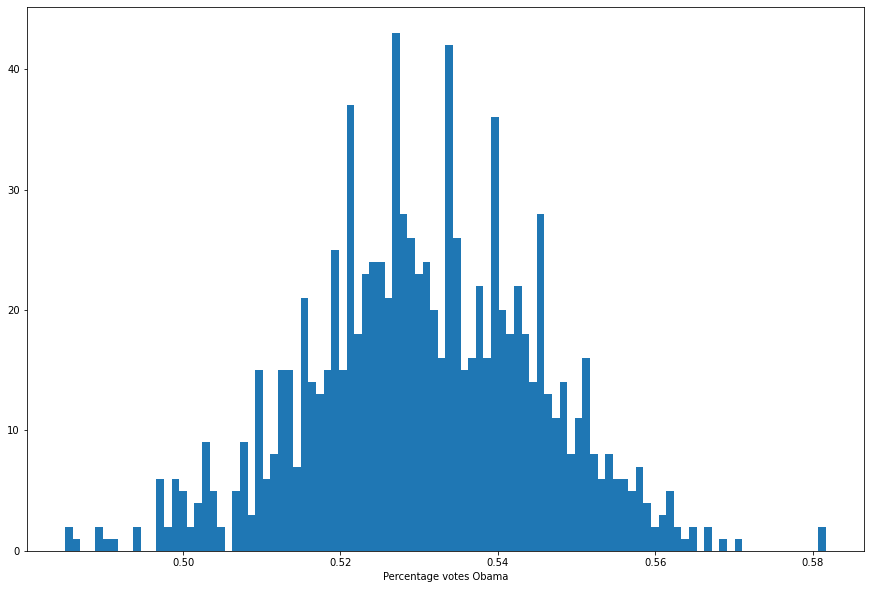

In [25]:
#your code here
plt.figure(figsize=(15,10))
plt.hist(sim_numpy, bins=100)
plt.xlabel('Percentage votes Obama')
plt.show()

Answer: looks normally distributed

What is the standard error (SE) of the estimated percentage from the poll. 

**Hint**: Remember the SE is the standard deviation (SD) of the distribution of a random variable. 

In [26]:
#your code here
se1 = np.std(sim_numpy)
se1

0.014707535648813202

#### Problem 2(c)

Now suppose we run M polls where M is the number of polls that happened in November (calculated in Problem 2(a)). Run 1,000 simulations and compute the mean of the M polls for each simulation. 

In [27]:
#your code here
sim_numpy = [((np.random.binomial(N, p, size=M)).mean())/N for i in range(1000)]
sim_numpy[:6]

[0.5265350877192982,
 0.5291666666666667,
 0.5263157894736842,
 0.5271929824561403,
 0.5256140350877193,
 0.5270175438596492]

What is the distribution of the average of polls?

**Hint**: Show a plot. 

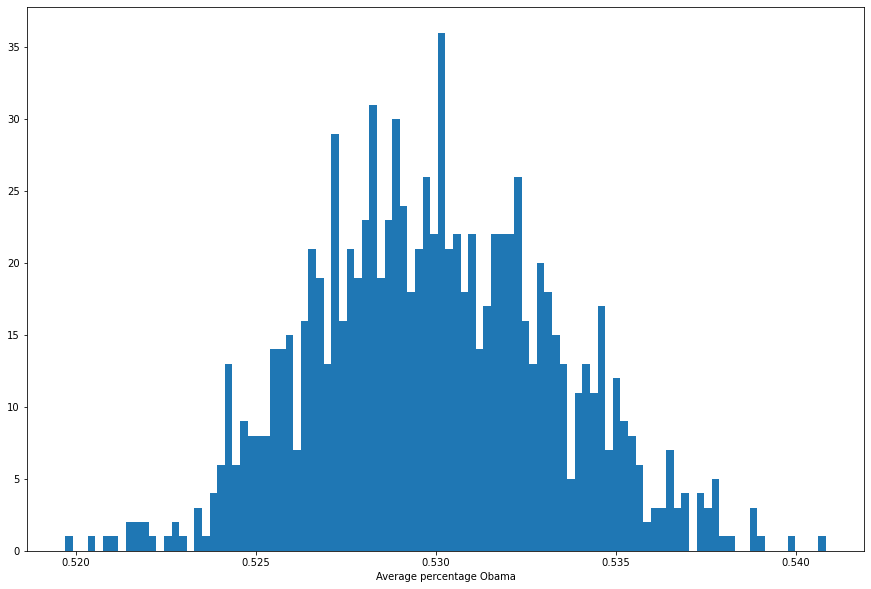

In [28]:
#your code here
plt.figure(figsize=(15,10))
plt.hist(sim_numpy, bins=100)
plt.xlabel('Average percentage Obama')
plt.show()

Answer: seems normally distributed

What is the standard error (SE) of the average of polls? 

In [29]:
#your code here
seM = np.std(sim_numpy)
seM

0.0033708836527100304

Answer: standard error SE of the average of polls is ~0.00332 percentage

Is the SE of the average of polls larger, the same, or smaller than that the SD of a single poll (calculated in Problem 2(b))? By how much?

**Hint**: Compute a ratio of the two quantities.  

In [30]:
#your code here
se1/seM

4.363109844206293

Answer: the standard error of one singe sample is more than 4 times the SE of the average of M polls.

#### Problem 2(d) 

Repeat Problem 2(c) but now record the *across poll* standard deviation in each simulation. 

In [31]:
#your code here
sim_numpy = [((np.random.binomial(N, p, size=M)).std())/N for i in range(1000)]
sim_numpy[:6]

[0.014033991185235142,
 0.011935789272546387,
 0.013722954598694149,
 0.014438420625221292,
 0.012865314326187432,
 0.017572892643595777]

What is the distribution of the *across M polls* standard deviation?

**Hint**: Show a plot. 

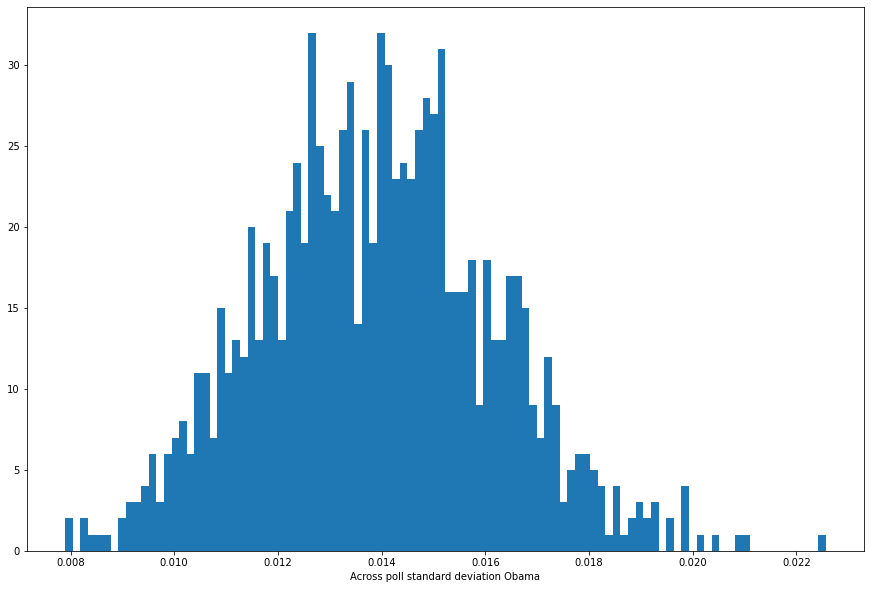

In [32]:
#your code here
plt.figure(figsize=(15,10))
plt.hist(sim_numpy, bins=100)
plt.xlabel('Across poll standard deviation Obama')
plt.show()

Answer: again an approximately normal distribution

#### Problem 2(e) 

What is the standard deviation of M polls in our real (not simulated) 2012 presidential election data ? 

In [33]:
#your code here. Devide by 100 
seR = pollsNovember.Obama.std()/100
seR

0.010841764600337107

Is this larger, the same, or smaller than what we expeced if polls were not biased.

In [34]:
#your code here
seR/np.mean(sim_numpy)

0.7792023780225026

Answer: the standard error of M polls of real election data is less than expected: ~0.78 times the SE of the average of the across polls.

#### Problem 2(f)

**For AC209 Students**: Learn about the normal approximation for the binomial distribution and derive the results of Problem 2(b) and 2(c) analytically (using this approximation). Compare the results obtained analytically to those obtained from simulations.

In [30]:
#your code here

Answer: 

## Discussion for Problem 2

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

---
October 2020:  CS109 - 2015 Lab3 explains an election model for the 2012 elections which was helpful in understanding some of the Problem 2 tasks. 
* using `duplicateRowsDF = pollsNovember[pollsNovember.duplicated()]` no duplicates were found
* when simulating 1000 times, the standard deviation of a single poll is higher than the SD of M polls. 
* when simulating 1000 times, the across polls standard deviation of M polls is about 1/0.78 higher than the SD of the real November 2012 Obama polls (M) => no pollster bias
* 2(b) besides `numpy.random.binomial()` a test using `binom.rvs` (scipy) was successfull as well
<br><br>

Remark: xrange() is deprecated in Python3

## Problem 3: Is the average of polls better than just one poll?

#### Problem 3(a)

Most undecided voters vote for one of the two candidates at the election. Therefore, the reported percentages underestimate the final value of both candidates. However, if we assume the undecided will split evenly, then the observed difference should be an unbiased estimate of the final difference. 

Add a new column to the `election` DataFrame containg the difference between Obama and Romeny called `Diff`. 

In [35]:
#your code here
election['Diff'] = election['Obama']/100 - election['Romney']/100
election.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Other,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration,Diff
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06T08:40:26Z,1000.0,Likely Voters,Live Phone,47.0,47.0,6.0,NaN,https://elections.huffingtonpost.com/pollster/...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None,NaN,1,0.00
1,YouGov/Economist,2012-11-03,2012-11-05,2012-11-26T15:31:23Z,740.0,Likely Voters,Internet,49.0,47.0,3.0,NaN,https://elections.huffingtonpost.com/pollster/...,http://cdn.yougov.com/cumulus_uploads/document...,Nonpartisan,None,NaN,1,0.02
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06T09:22:02Z,872.0,Likely Voters,Automated Phone,48.0,48.0,4.0,NaN,https://elections.huffingtonpost.com/pollster/...,http://www.gravispolls.com/2012/11/gravis-mark...,Nonpartisan,None,NaN,1,0.00
3,IBD/TIPP,2012-11-03,2012-11-05,2012-11-06T08:51:48Z,712.0,Likely Voters,Live Phone,50.0,49.0,NaN,1.0,https://elections.huffingtonpost.com/pollster/...,http://news.investors.com/special-report/50841...,Nonpartisan,None,NaN,1,0.01
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06T08:47:50Z,1500.0,Likely Voters,Automated Phone,48.0,49.0,NaN,NaN,https://elections.huffingtonpost.com/pollster/...,http://www.rasmussenreports.com/public_content...,Nonpartisan,None,NaN,1,-0.01


#### Problem 3(b)

Make a plot of the differences for the week before the election (e.g. 5 days) where the days are on the x-axis and the differences are on the y-axis.  Add a horizontal line showing 3.9%: the difference between Obama and Romney on election day.

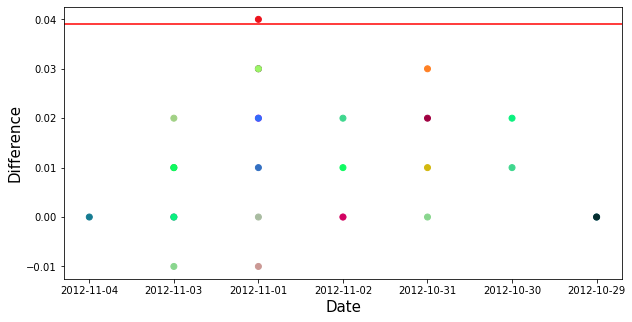

In [36]:
#your code here
# election day 2012: 2012-11-06
electionSub = election[(election['Start Date'] > '2012-10-28') & (election['Start Date'] < '2012-11-06')]
colour_dict = {}
for p in set(electionSub['Pollster']):
    colour_dict[p] = np.random.rand(3,)
plt.figure(figsize=(10,5))
plt.scatter(electionSub['Start Date'], electionSub['Diff'], c=list(map(lambda x: colour_dict[x], electionSub['Pollster'])))
plt.axhline(y = 0.039, color='r')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Difference', fontsize=15)
plt.show()

#### Problem 3(c) 

Make a plot showing the differences by pollster where the pollsters are on the x-axis and the differences on the y-axis. 

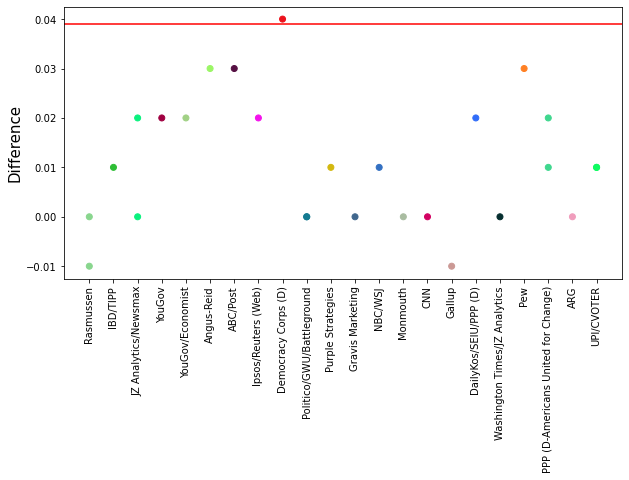

In [37]:
pollster_dict = {}
for i, p in enumerate(set(electionSub['Pollster'])):
    pollster_dict[p] = i
plt.figure(figsize=(10,5))
plt.scatter(list(map(lambda x: pollster_dict[x], electionSub['Pollster'])), electionSub['Diff'], c=list(map(lambda x: colour_dict[x], electionSub['Pollster'])))
plt.ylabel('Difference', fontsize=15)
# get key (pollster name) from pollster_dict. How easy this is in Smalltalk: keyAtValue: value
xlabels =[list(pollster_dict.keys())[list(pollster_dict.values()).index(i)] for i in range(len(pollster_dict))]
plt.xticks(list(pollster_dict.values()), xlabels, rotation='vertical')
plt.axhline(y = 0.039, color='r')
plt.show()

Is the *across poll* difference larger than the *between pollster* difference? 

Answer: quite some difference between pollsters

#### Problem 3(d)

Take the average for each pollster and then compute the average of that. Given this difference how confident would you have been of an Obama victory?

**Hint**: Compute an estimate of the SE of this average based exclusively on the observed data. 

In [38]:
#your code here
avgs = electionSub.groupby('Pollster').mean()
print('Average of the average for each pollster', avgs.Diff.mean())
print('Standard error (SE) of the average ', np.std(avgs.Diff))

Average of the average for each pollster 0.011818181818181818
Standard error (SE) of the average  0.012928602412116267


Answer: The SE is larger than the diff in win between Obama and Romney average across the pollster averages. This makes an Obama victory uncertain.

#### Problem 3(e)

**For AC209 Students**: Show the difference against time and see if you can detect a trend towards the end. Use this trend to see if it improves the final estimate.

In [35]:
#your code here

Answer: 

## Discussion for Problem 3

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

---
October 2020: one week before the elections almost all pollsters showed an Obama-Romney difference less than 3,9% on election day. 

## Problem 4

In this last problem, we will use the polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to create a preliminary prediction of the result of each state. 

The HuffPost Pollster API allows you to access the data as a CSV or a JSON response by tacking ".csv" or ".json" at the end of the URLs. For example the 2012 Presidential Election could be accessed as a [.json](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.json) instead of a [.csv](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv)

#### Problem 4(a)

Read in the polls for **all** of the 2014 Senate Elections using the HuffPost API. For example, we can consider the [2014 Senate race in Kentucky between Mitch McConnell and Alison Grimes](http://elections.huffingtonpost.com/pollster/2014-kentucky-senate-mcconnell-vs-grimes). 

To search for the 2014 Senate races, use the `topics` parameter in the API [[read more about topics here](http://elections.huffingtonpost.com/pollster/api)].  

In [39]:
url_str = "http://elections.huffingtonpost.com/pollster/api/charts/?topic=2014-senate"

To list all the URLs related to the 2014 Senate races using the pollster API, we can use a list comprehension:

In [40]:
election_urls = [election['url'] + '.csv' for election in requests.get(url_str).json()]
election_urls

['https://elections.huffingtonpost.com/pollster/2014-delaware-senate-wade-vs-coons.csv',
 'https://elections.huffingtonpost.com/pollster/2014-massachusetts-senate-herr-vs-markey.csv',
 'https://elections.huffingtonpost.com/pollster/2014-rhode-island-senate-zaccaria-vs-reed.csv',
 'https://elections.huffingtonpost.com/pollster/2014-montana-senate-daines-vs-curtis.csv',
 'https://elections.huffingtonpost.com/pollster/2014-oklahoma-senate-lankford-vs-johnson.csv',
 'https://elections.huffingtonpost.com/pollster/2014-hawaii-senate-cavasso-vs-schatz.csv',
 'https://elections.huffingtonpost.com/pollster/2014-kansas-senate-roberts-vs-orman-vs-taylor.csv',
 'https://elections.huffingtonpost.com/pollster/2014-wyoming-senate.csv',
 'https://elections.huffingtonpost.com/pollster/2014-tennessee-senate-alexander-vs-ball.csv',
 'https://elections.huffingtonpost.com/pollster/2014-idaho-senate-risch-vs-mitchell.csv',
 'https://elections.huffingtonpost.com/pollster/2014-new-jersey-senate-bell-vs-booker

Because there so many Senate races, we can create a dictionary of pandas DataFrames that will be keyed by the name of the election (a string). 

In [41]:
def build_frame(url):
    """
    Returns a pandas DataFrame object containing
    the data returned from the given url
    """
    source = requests.get(url).text
    
    # Use StringIO because pd.DataFrame.from_csv requires .read() method
    s = StringIO(source)
    
    my_df=pd.read_csv(s, index_col=None)
    return my_df
 

In [42]:
# Makes a dictionary of pandas DataFrames keyed on election string.
dfs = dict((election.split("/")[-1][:-4], build_frame(election)) for election in election_urls)

Show the head of the DataFrame containing the polls for the 2014 Senate race in Kentucky between McConnell and Grimes.

In [43]:
#your code here
dfs['2014-kentucky-senate-mcconnell-vs-grimes'][:5]

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Grimes,McConnell,Undecided,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration
0,PPP (D),2014-10-30,2014-11-01,2014-11-02T01:44:58Z,1503,Likely Voters,IVR/Online,42.0,50.0,NaN,https://elections.huffingtonpost.com/pollster/...,http://www.publicpolicypolling.com/pdf/2014/PP...,Pollster,Dem,NaN,1
1,NBC/Marist,2014-10-27,2014-10-30,2014-11-02T14:37:22Z,556,Likely Voters,Live Phone,41.0,50.0,3.0,https://elections.huffingtonpost.com/pollster/...,http://newscms.nbcnews.com/sites/newscms/files...,Nonpartisan,None,NaN,1
2,SurveyUSA/Courier-Journal/Herald-Leader/WHAS/WKYT,2014-10-25,2014-10-29,2014-10-30T23:33:59Z,597,Likely Voters,IVR/Online,43.0,48.0,6.0,https://elections.huffingtonpost.com/pollster/...,http://www.surveyusa.com/client/PollReport.asp...,Nonpartisan,None,NaN,1
3,POS (R-Crossroads GPS),2014-10-25,2014-10-27,2014-10-30T20:56:18Z,600,Likely Voters,Live Phone,43.0,50.0,NaN,https://elections.huffingtonpost.com/pollster/...,https://www.crossroadsgps.org/wp-content/uploa...,Sponsor,Rep,NaN,1
4,CBS/NYT/YouGov,2014-10-16,2014-10-23,2014-10-26T15:00:07Z,1502,Likely Voters,Internet,39.0,45.0,14.0,https://elections.huffingtonpost.com/pollster/...,https://today.yougov.com/news/2014/09/07/battl...,Nonpartisan,None,NaN,1


#### Problem 4(b)

For each 2014 Senate race, create a preliminary prediction of the result for that state.

In [44]:
#your code here
# How to tackle this one? Try the difference between the candidates (as in Problem 3)

predict_list = []
for state in dfs:
    predict_dict =  {}
    df = dfs[state]
    df['Diff'] = df[df.columns[7]]/100 - df[df.columns[8]]/100
    avgs = df['Diff'].mean()
    predict_dict = {'State':state, 'candidate1':df.columns[7], 'candidate2':df.columns[8], 'Diff':avgs, 'Winner':df.columns[7] if avgs > 0 else df.columns[8] }
    predict_list.append(predict_dict)
predict_df = pd.DataFrame(predict_list) 
predict_df

,State,candidate1,candidate2,Diff,Winner
0,2014-delaware-senate-wade-vs-coons,Coons,Wade,0.174000,Coons
1,2014-massachusetts-senate-herr-vs-markey,Markey,Herr,0.224615,Markey
2,2014-rhode-island-senate-zaccaria-vs-reed,Zaccaria,Reed,-0.355000,Reed
3,2014-montana-senate-daines-vs-curtis,Curtis,Daines,-0.171429,Daines
4,2014-oklahoma-senate-lankford-vs-johnson,Lankford,Johnson,0.311250,Lankford
5,2014-hawaii-senate-cavasso-vs-schatz,Schatz,Cavasso,0.403750,Schatz
6,2014-kansas-senate-roberts-vs-orman-vs-taylor,Taylor,Roberts,-0.183750,Roberts
7,2014-wyoming-senate,Hardy,Enzi,-0.448000,Enzi
8,2014-tennessee-senate-alexander-vs-ball,Alexander,Ball,0.190000,Alexander
9,2014-idaho-senate-risch-vs-mitchell,Risch,Mitchell,0.298333,Risch


# Submission Instructions

To submit your homework, create a folder named **lastname_firstinitial_hw#** and place your IPython notebooks, data files, and any other files in this folder. Your IPython Notebooks should be completely executed with the results visible in the notebook. We should not have to run any code.  Compress the folder (please use .zip compression) and submit to the CS109 dropbox in the appropriate folder. *If we cannot access your work because these directions are not followed correctly, we will not grade your work.*
